# Import dependencies and load the csv file

In [1]:
# Data handling
import pandas as pd
import numpy as np

# Machine learning model and splitting the data
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Metrics for evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the data (replace 'file.csv' with your actual file path)
complete_df = pd.read_csv('Resources/complete_data.csv')

# Convert 'Date' column to datetime format
complete_df['Date'] = pd.to_datetime(complete_df['Date'], errors='coerce')

# Display the results
complete_df.head()

,Date,Index SA,Redfin HPI MoM,Case Shiller Index MoM,period_duration,region_type,table_id,is_seasonally_adjusted,region,state,...,price_drops,price_drops_mom,price_drops_yoy,off_market_in_two_weeks,off_market_in_two_weeks_mom,off_market_in_two_weeks_yoy,30_Year_%,price_drops_is_blank,price_drops_mom_is_blank,price_drops_yoy_is_blank
0,2012-01-01,59.9,0.00%,-0.00048,30,state,23,f,Oklahoma,Oklahoma,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,3.915,True,True,True
1,2012-01-01,59.9,0.00%,-0.00048,30,state,10,f,New Hampshire,New Hampshire,...,0.000000,0.000000,0.0,0.007093,0.000636,-0.000240,3.915,True,True,True
2,2012-01-01,59.9,0.00%,-0.00048,30,state,42,f,Virginia,Virginia,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,3.915,True,True,True
3,2012-01-01,59.9,0.00%,-0.00048,30,state,47,f,Michigan,Michigan,...,0.000000,0.000000,0.0,0.013045,-0.000528,0.000734,3.915,True,True,True
4,2012-01-01,59.9,0.00%,-0.00048,30,state,12,f,New Jersey,New Jersey,...,0.000549,0.000502,0.0,0.007897,0.001832,0.006060,3.915,False,False,True


## Complete Pre-processing to ensure all fields have values to run in the Random Forest Model

In [3]:
# Convert categorical columns using one-hot encoding
complete_df = pd.get_dummies(complete_df, columns=['region_type', 'is_seasonally_adjusted', 
                                                   'region', 'state', 'property_type'], drop_first=True)

In [4]:
# Clean and convert any Percentage Strings
complete_df['Redfin HPI MoM'] = complete_df['Redfin HPI MoM'].str.rstrip('%').astype(float) / 100

In [5]:
# Select only numeric columns from the DataFrame
numeric_df = complete_df.select_dtypes(include=[np.number])

constant_columns = [col for col in numeric_df.columns if numeric_df[col].nunique() == 1]
print(f"Columns with constant values: {constant_columns}")

Columns with constant values: ['period_duration']


In [6]:
# Fill any missing values with the mean
complete_df = complete_df.fillna(complete_df.mean())

## Split the data into training (1/1/2014 - 2/28/2013) and testing sets (3/1/23 - 9/30/2024) and define our target. `median_sales_price`.

In [7]:
# Split the dataset into training and testing sets based on the Date column
train_data = complete_df[(complete_df['Date'] >= '2014-01-01') & (complete_df['Date'] <= '2023-2-28')]
test_data = complete_df[(complete_df['Date'] >= '2023-03-01') & (complete_df['Date'] <= '2024-09-30')]

# Check the split
print(f"Training data: {len(train_data)} rows")
print(f"Testing data: {len(test_data)} rows")

Training data: 27407 rows
Testing data: 4760 rows


In [8]:
# Drop the Date column along with redundant columns
columns_to_drop = ['Date', 'Case Shiller Index MoM', 'period_duration', 'table_id']  

# Define the train and test data
train_data = train_data.drop(columns=columns_to_drop)
test_data = test_data.drop(columns=columns_to_drop)

In [9]:
# Define the target variable (y)
y_train = train_data['median_sale_price']
y_test = test_data['median_sale_price']

# Define the features (X) by dropping only the target column 
X_train = train_data.drop(columns=['median_sale_price'])
X_test = test_data.drop(columns=['median_sale_price'])

In [10]:
# Confim the X_train and X_test and y_train, y_test have same number of rows

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (27407, 151), y_train shape: (27407,)
X_test shape: (4760, 151), y_test shape: (4760,)


In [11]:
# Confirm all test and train have same set of features
X_train, X_test = X_train.align(X_test, join='inner', axis=1)

In [12]:
# Show Results
X_train.head()

,Index SA,Redfin HPI MoM,median_sale_price_mom,median_sale_price_yoy,median_list_price,median_list_price_mom,median_list_price_yoy,median_ppsf,median_ppsf_mom,median_ppsf_yoy,...,state_Vermont,state_Virginia,state_Washington,state_West Virginia,state_Wisconsin,state_Wyoming,property_type_Condo/Co-op,property_type_Multi-Family (2-4 Unit),property_type_Single Family Residential,property_type_Townhouse
463,70.2,0.0055,-0.037800,0.110405,190800.0,0.134566,0.102945,95.0,-0.035293,0.102496,...,False,False,False,False,False,False,False,False,True,False
464,70.2,0.0055,0.131444,0.188754,212500.0,0.015022,0.090986,93.0,0.020217,0.092158,...,False,False,False,False,False,False,False,False,False,True
465,70.2,0.0055,-0.049406,-0.047143,126100.0,0.464968,0.073709,60.0,-0.128450,-0.046997,...,False,False,False,False,False,False,False,False,False,True
466,70.2,0.0055,-0.038744,0.231477,412100.0,0.086573,0.157841,248.0,-0.027588,0.249806,...,False,False,False,False,False,False,False,False,False,False
467,70.2,0.0055,-0.109733,0.025714,190000.0,0.188243,0.188243,85.0,-0.167753,0.013070,...,False,False,False,False,False,False,False,False,False,True


## Initialize, Train and fit our Random Forest model - Use Regressor as target variable `median_sales_price` is continuous.

In [13]:
# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)

In [14]:
# Fit the model on the training data
rf_model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=50, n_jobs=-1, random_state=42)

In [15]:
# Use the model to predict on the test data
y_pred = rf_model.predict(X_test)

# Evaluate the performance

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the results
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R² Score: {r2}")

Mean Squared Error: 5517830177.106723
Mean Absolute Error: 32727.75
R² Score: 0.8586994686077691


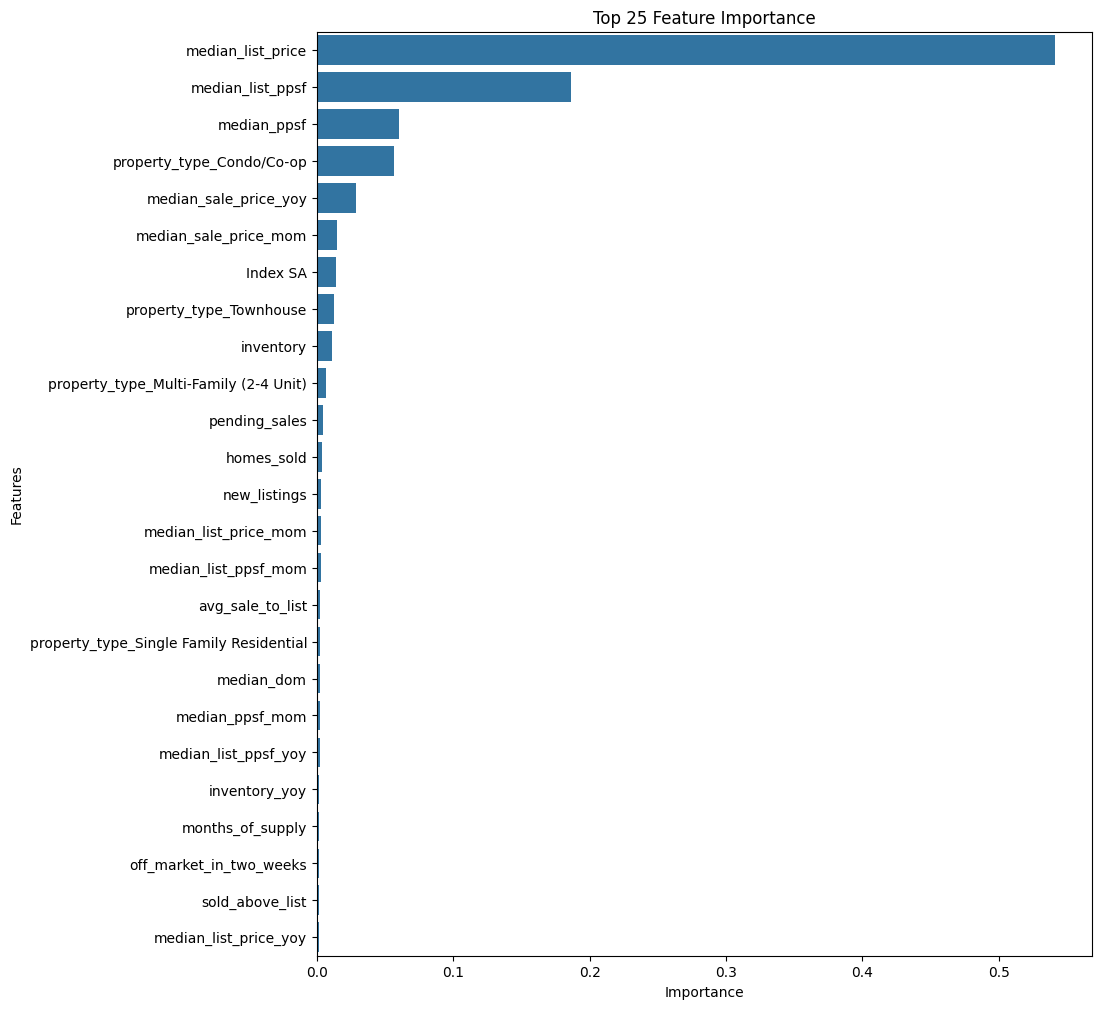

In [17]:
# Extract feature importances from the trained model
importances = rf_model.feature_importances_

# Get the feature names (columns in X_train)
feature_names = X_train.columns

# Sort the features by importance (descending order)
sorted_indices = importances.argsort()[::-1]
top_n = 25  # Number of top features to select
top_features = feature_names[sorted_indices][:top_n]
top_importances = importances[sorted_indices][:top_n]

# Plot the top 25 features
plt.figure(figsize=(10, 12))
sns.barplot(y=top_features, x=top_importances, orient="h")
plt.title("Top 25 Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Features")

# Save the plot as a PNG file
plt.savefig('Resources/top_25_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

## Now Re-run the model using Top 25 features and increase the `n_estimators=75`.

In [19]:
# Filter the datasets to include only the top 25 features
X_train_top25 = X_train[top_features]
X_test_top25 = X_test[top_features]

In [20]:
# Initialize the model with updated parameters
rf_model_top25 = RandomForestRegressor(n_estimators=75, random_state=42, n_jobs=-1)

In [21]:
# Fit the model using only the top 25 features
rf_model_top25.fit(X_train_top25, y_train)

RandomForestRegressor(n_estimators=75, n_jobs=-1, random_state=42)

In [22]:
# Predict using the updated model
y_pred_top25 = rf_model_top25.predict(X_test_top25)

In [23]:
# Evaluate the model
mse_top25 = mean_squared_error(y_test, y_pred_top25)
mae_top25 = mean_absolute_error(y_test, y_pred_top25)
r2_top25 = r2_score(y_test, y_pred_top25)

# Print the results
print(f"Mean Squared Error: {mse_top25}")
print(f"Mean Absolute Error: {mae_top25}")
print(f"R² Score: {r2_top25}")

Mean Squared Error: 5085714241.454716
Mean Absolute Error: 32232.699439775904
R² Score: 0.8697650884929203


## Update to `n_estimators=100`

In [24]:
# Re-Initialize with 100 estimators
rf_model_top25 = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

In [25]:
# Train the new model on X_train_top25 and y_train
rf_model_top25.fit(X_train_top25, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [26]:
# Re-make predictions
y_pred_top25 = rf_model_top25.predict(X_test_top25)

In [27]:
# Re-check the results
mse_top25 = mean_squared_error(y_test, y_pred_top25)
mae_top25 = mean_absolute_error(y_test, y_pred_top25)
r2_top25 = r2_score(y_test, y_pred_top25)

print(f"Mean Squared Error: {mse_top25}")
print(f"Mean Absolute Error: {mae_top25}")
print(f"R² Score: {r2_top25}")

Mean Squared Error: 5020646666.956933
Mean Absolute Error: 31887.499789915968
R² Score: 0.8714313381885137


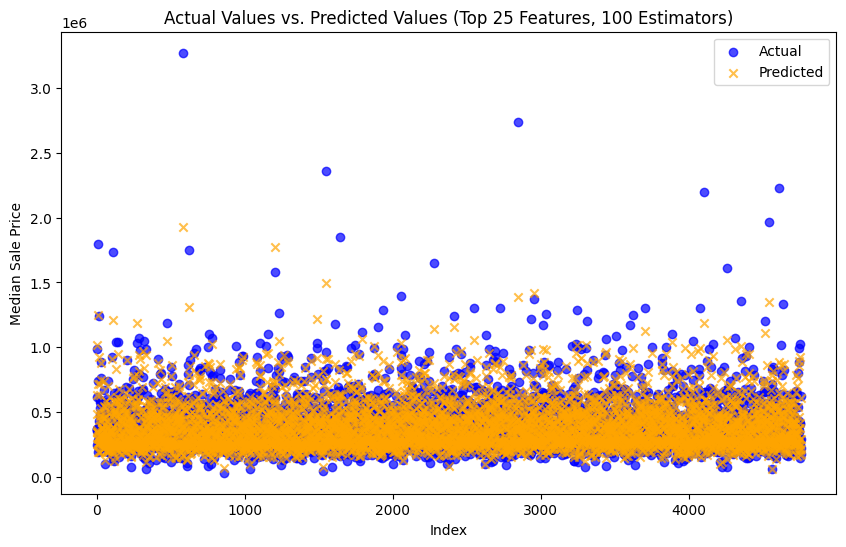

In [28]:
# Generate predictions from the best model
y_pred_top25 = rf_model_top25.predict(X_test_top25)  # Ensure you're using Top 25 features

# Create the scatter plot for 'Actual' vs 'Predicted' results
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, label="Actual", color="blue", alpha=0.7)
plt.scatter(range(len(y_pred_top25)), y_pred_top25, label="Predicted", color="orange", alpha=0.7, marker='x')
plt.xlabel("Index")
plt.ylabel("Median Sale Price")
plt.title("Actual Values vs. Predicted Values (Top 25 Features, 100 Estimators)")
plt.legend()
plt.show()

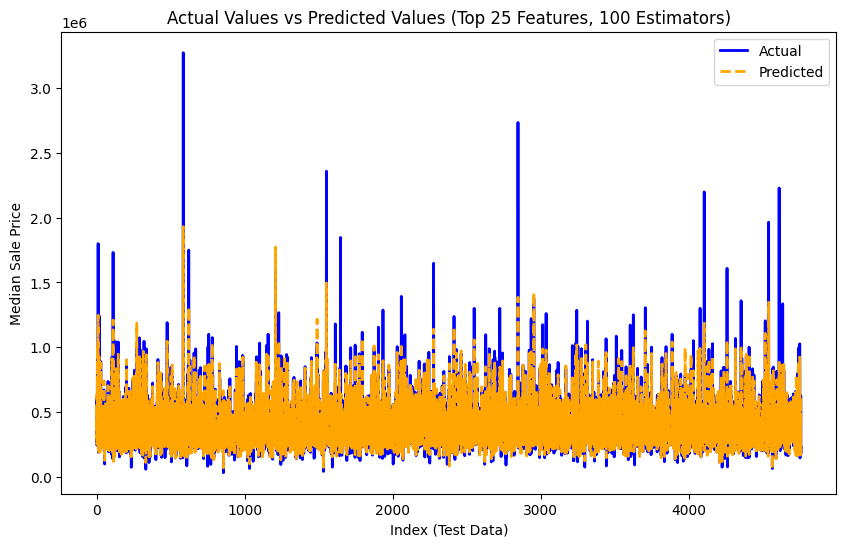

In [29]:
# Create a Line graph for 'Actual' vs 'Predicted' Results

# Use the range for the x-axis (indices of the test data)
plt.figure(figsize=(10, 6))
x = np.arange(len(y_test))  # Sequential index from 0 to the length of y_test

# Plot the two lines: Actual and Predicted
plt.plot(x, y_test.values, label='Actual', color='blue', linewidth=2)  
plt.plot(x, y_pred_top25, label='Predicted', color='orange', linewidth=2, linestyle='--') 

# Add labels, title, and legend
plt.xlabel('Index (Test Data)')
plt.ylabel('Median Sale Price')
plt.title('Actual Values vs Predicted Values (Top 25 Features, 100 Estimators)')
plt.legend()

# Show the plot
plt.show()

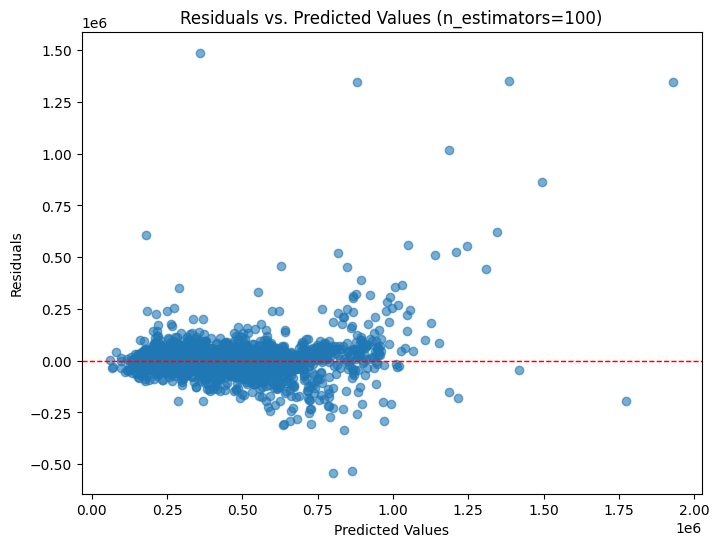

In [30]:
# Residuals for the best model
residuals = y_test - y_pred_top25  # Use predictions from the best model

# Scatterplot of residuals to detect patterns
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_top25, residuals, alpha=0.6)
plt.axhline(0, color="red", linestyle="--", linewidth=1)
plt.title("Residuals vs. Predicted Values (n_estimators=100)")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

In [31]:
# Calculate the difference and round to 2 decimal places to mirror actual dollar figure format

# Set up the rounding to 2 decimal places
actual_values = np.round(y_test.values, 2)  
predicted_values = np.round(y_pred_top25, 2)  
differences = np.round(actual_values - predicted_values, 2)  

# Create the results DataFrame
results = pd.DataFrame({
    'Actual': actual_values,
    'Predicted': predicted_values,
    'Difference': differences
})

# Save the results to a CSV file
results.to_csv('Resources/random_forest_results.csv', index=False)

# Confirm the saved file contains properly rounded values
print("Results saved with Actual, Predicted and Difference columns!")

Results saved with Actual, Predicted and Difference columns!
